In [13]:
# import necessary packages
import json
import requests
import pandas as pd
import polyline
import geopandas as gpd
from shapely.geometry import LineString, Point
import numpy as np
from itertools import product
from haversine import haversine, Unit
from shapely.ops import nearest_points
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [49]:
def create_pt_grid(minx, miny, maxx, maxy):
    """creates a grid of points (lat/longs) in the range specified. lat longs 
    are rounded to hundredth place

    Args:
        minx: minimum longitude
        miny: minimum latitude
        maxx: maximum longitude
        maxy: maximum latitude

    Returns: DataFrame of all lat/long combinations in region
    """
    lats = range(int(miny*1000), int(maxy*1000 +1))
    longs = range(int(minx*1000), int(maxx*1000 +1))
    ll_df = pd.DataFrame(product(lats, longs), 
                    columns=['lat1000', 'long1000'])
    ll_df['geometry'] = [Point(x, y) for x, y in zip(ll_df['long1000'], 
                                                     ll_df['lat1000'])]
    return ll_df

In [ ]:
def get_pts_near_path(line, distance):
    """returns all lat/longs within specified distance of line that are in 
    manhattan
    
    Args:
        line: shapely linestring of route
        distance: maximum distance from path for returned points

    Returns:
        pandas dataframe of all points within distance from line
    """
    # get line bounds
    (minx, miny, maxx, maxy) = line.bounds
    
    # extract max/min values with buffer area
    minx = round(minx, 3) -0.002
    miny = round(miny, 3) -0.002
    maxx = round(maxx, 3) + 0.002
    maxy = round(maxy, 3) + 0.002

    # load manhattan lat_longs
    manhattan_pts = pd.read_csv('models/man_lat_longs.csv')

    # brute force fix for floating point error
    manhattan_pts['latitude'] = manhattan_pts['lat1000']/1000
    manhattan_pts['longitdue'] = manhattan_pts['long1000']/1000
    manhattan_pts = manhattan_pts.loc[:, ['latitude', 'longitude']]
    
    # create a df of all lat, longs w/in bounds
    all_pts = create_pt_grid(minx, miny, maxx, maxy)
    
    # remove pts not in manhattan
    all_pts = pd.merge(all_pts, manhattan_pts, 
                         on=['latitude', 'longitude'],
                         how='inner')

    # flag points in the grid in manhattan as on/within distance of path
    all_pts['on_path'] = get_on_path(all_pts['geometry'], distance, line)
    return pd.DataFrame(all_pts.loc[(all_pts['on_path']==True)])

In [57]:
practice_grid = create_pt_grid(-74.000, 40.750, -73.960183, 40.7800)

In [58]:
practice_grid_gdf = gpd.GeoDataFrame(practice_grid)

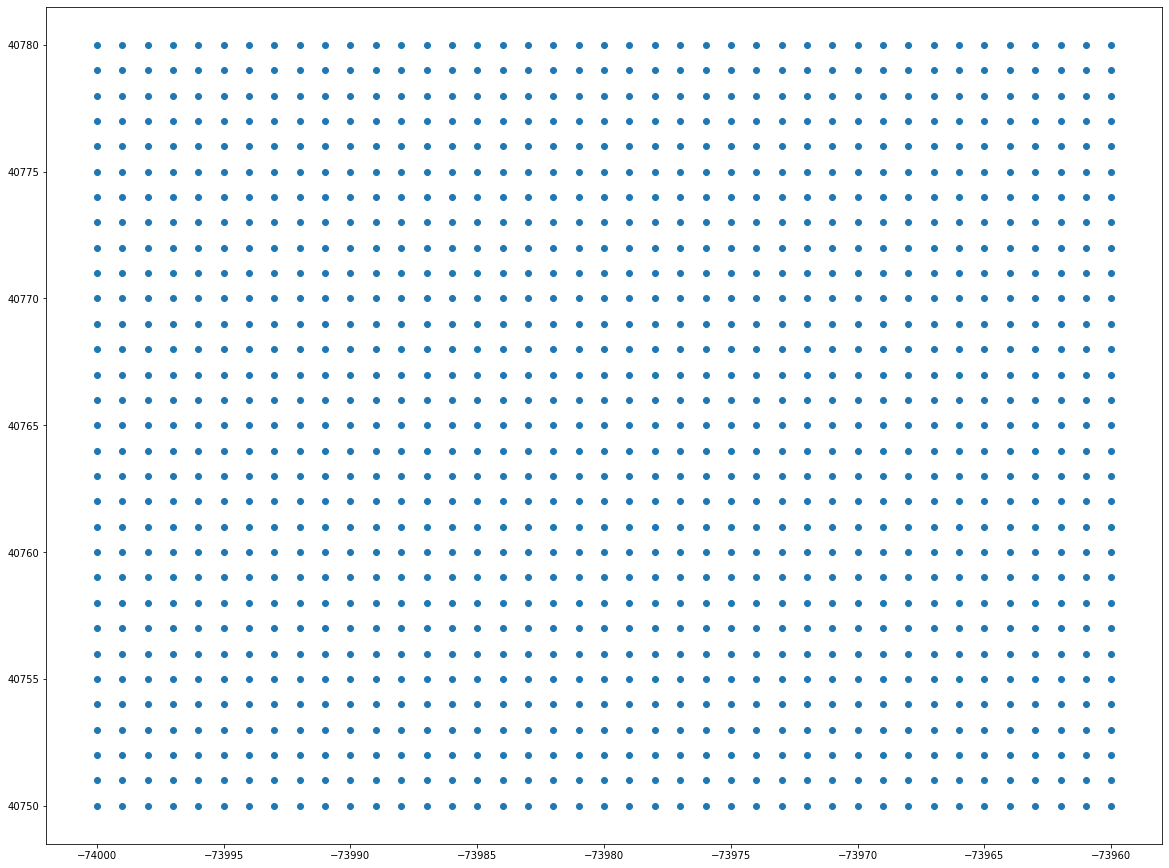

In [59]:
fig, ax = plt.subplots(figsize=(20,20))
practice_grid_gdf.plot(ax=ax)

In [85]:
manhattan_pts = pd.read_csv('/Users/allisonhonold/ds0805/walk_proj/walk_risk_engine/data/csv/man_lat_longs.csv')

In [86]:
manhattan_pts.head()

,lat1000,long1000,longitude,latitude,geometry,in_man
0,40683,-74023,-74.023,40.683,POINT (-74.023 40.683),True
1,40684,-74024,-74.024,40.684,POINT (-74.024 40.684),True
2,40684,-74012,-74.012,40.684,POINT (-74.012 40.684),True
3,40685,-74026,-74.026,40.685,POINT (-74.026 40.685),True
4,40685,-74025,-74.025,40.685,POINT (-74.02500000000001 40.685),True


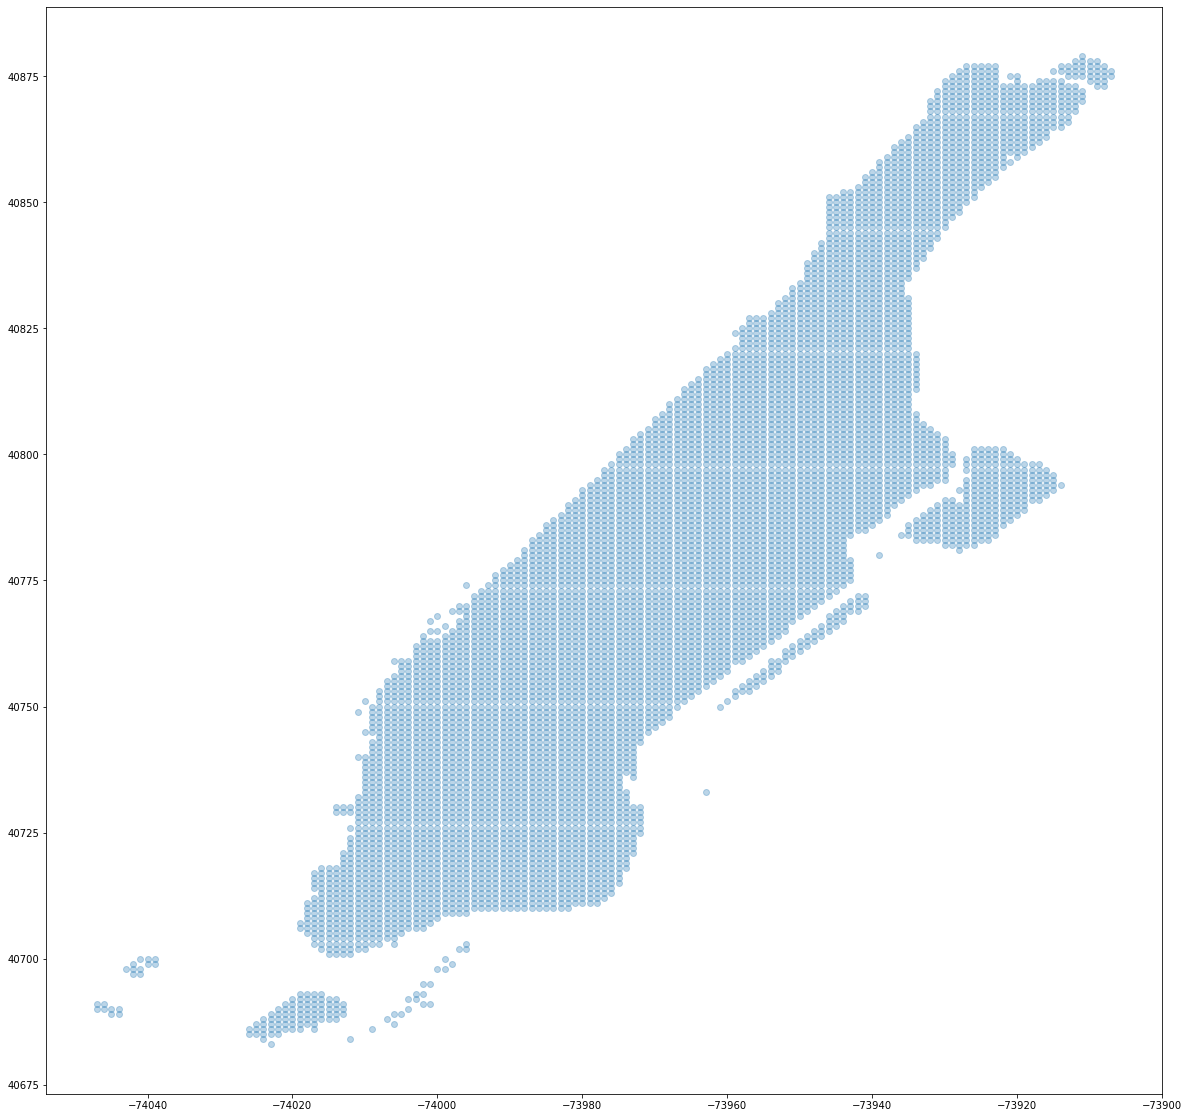

In [95]:
fig5, ax5 = plt.subplots(figsize=(20,20))
ax5.scatter(manhattan_pts['long1000'], manhattan_pts['lat1000'], alpha=.3)

In [92]:
all_pts = pd.merge(practice_grid_gdf, manhattan_pts.loc[:,['lat1000', 'long1000']], 
                         on=['lat1000', 'long1000'],
                         how='inner')

In [93]:
all_pts.head()

,lat1000,long1000,geometry
0,40750,-74000,POINT (-74000.000 40750.000)
1,40750,-73999,POINT (-73999.000 40750.000)
2,40750,-73998,POINT (-73998.000 40750.000)
3,40750,-73997,POINT (-73997.000 40750.000)
4,40750,-73996,POINT (-73996.000 40750.000)


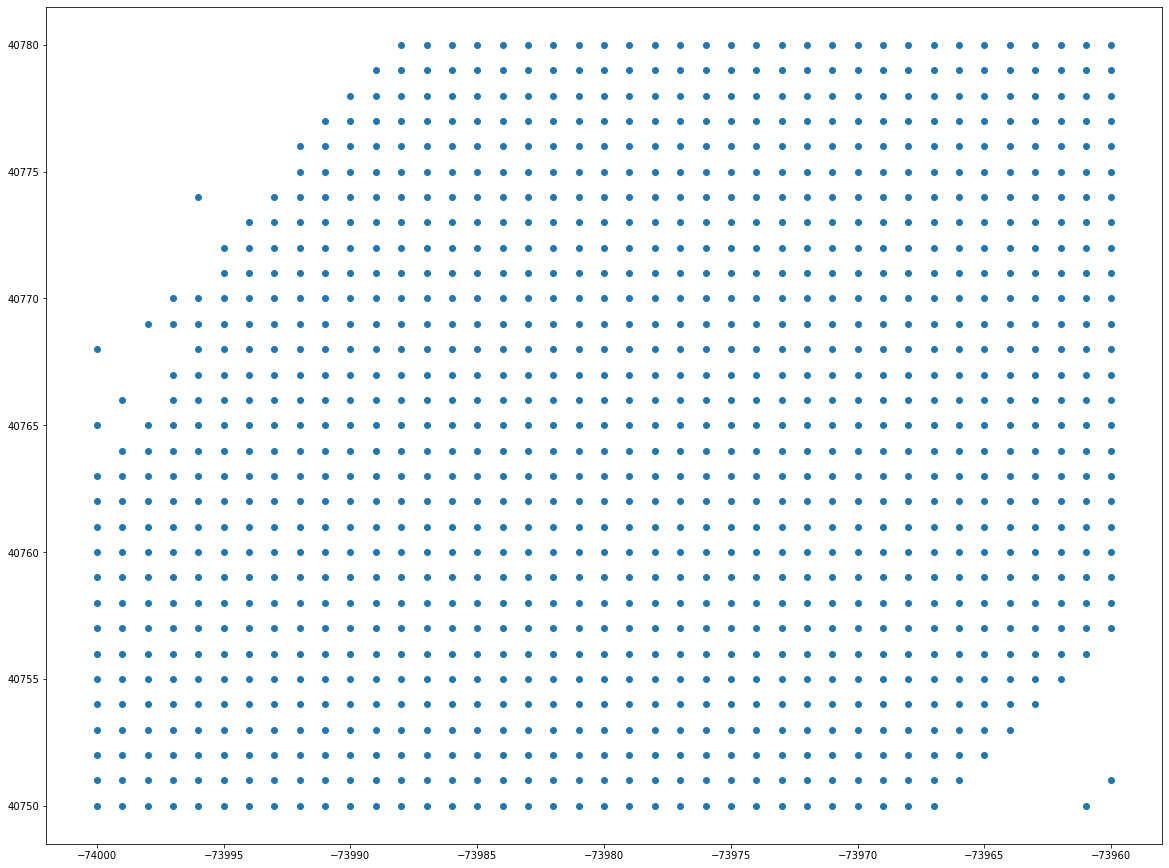

In [94]:
fig2, ax2 = plt.subplots(figsize=(20,20))
all_pts.plot(ax=ax2)

In [38]:
manhattan_pts.shape

(6312, 4)

In [39]:
practice_grid_gdf.shape

(1026, 3)

In [65]:
practice_grid_gdf.head()

,lat1000,long1000,geometry
0,40750,-74000,POINT (-74000.000 40750.000)
1,40750,-73999,POINT (-73999.000 40750.000)
2,40750,-73998,POINT (-73998.000 40750.000)
3,40750,-73997,POINT (-73997.000 40750.000)
4,40750,-73996,POINT (-73996.000 40750.000)


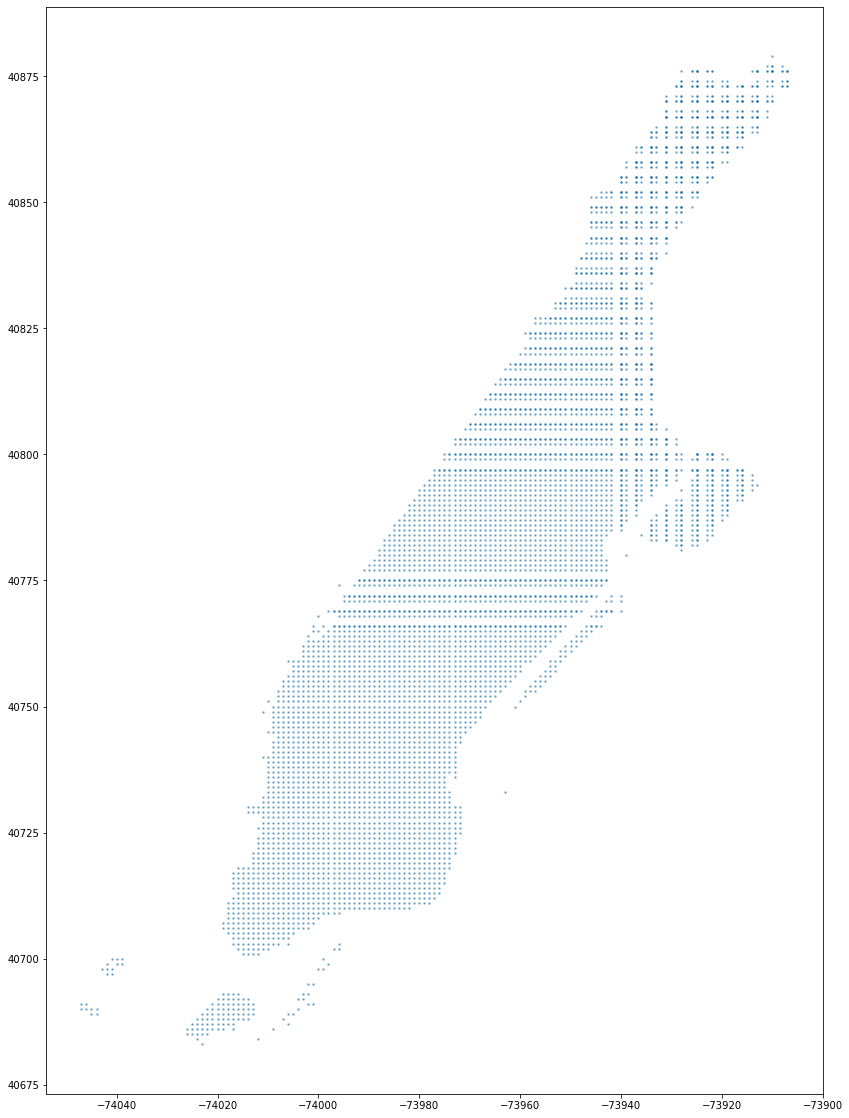

In [74]:
man_gdf = gpd.GeoDataFrame(manhattan_pts, geometry=[Point(x, y) for x, y in zip(manhattan_pts['long1000'], 
                                                     manhattan_pts['lat1000'])])
fig3, ax3 = plt.subplots(figsize=(20,20))
man_gdf.plot(ax=ax3, markersize=2, alpha=.5)